In [805]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [806]:
seed = 42

# Data preparation

In [807]:
def clean_df(df):
    return df

In [808]:
df = pd.read_csv("test_data.csv")
df = clean_df(df)

df_1 = df[~df["textB"].isna()] # are the two texts in the same language?
df_2 = df[df["textB"].isna()] # what language is textA?

# Subtask 1

In [809]:
df_1 = df_1.copy()

df_1.head()

,datapointID,textA,textB
7,1553,"unec, tler.","evenlicrcr cruch iicr feiicrlicrcr, biinquelic..."
8,1537,1688 1792 (giri seil enc heil).,"folealicr longueubel, bubellicr fleaom 1695 li..."
12,1439,"qia upied, xed evi.",e umpee e se j uesif arad unar pa. eeeq ued ue...
17,1322,crpolealicrcr cullicruleae crpolealicr concrbe...,"e boleagucleaecleagucleaecleacleaegeguclea"" be..."
33,1348,crpolealicrcr leiiguecr oleagiincrevbeiilicrbe...,e thi umpe iair uer e pai ind ins ire stad lid...


In [810]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=2, max_df=0.95, analyzer='char_wb', ngram_range=(2, 4)
)

# fit on the full corpus (textA + textB)
all_texts = pd.concat([df_1["textA"], df_1["textB"]])
tfidf_vectorizer.fit(all_texts)

# transform textA and textB separately
A_tfidf = tfidf_vectorizer.transform(df_1["textA"])
B_tfidf = tfidf_vectorizer.transform(df_1["textB"])

(array([203.,  60.,  22.,   9.,  11.,  13.,  17.,  11.,   2.,   2.]),
 array([0.        , 0.07025006, 0.14050011, 0.21075017, 0.28100023,
        0.35125029, 0.42150034, 0.4917504 , 0.56200046, 0.63225052,
        0.70250057]),
 <BarContainer object of 10 artists>)

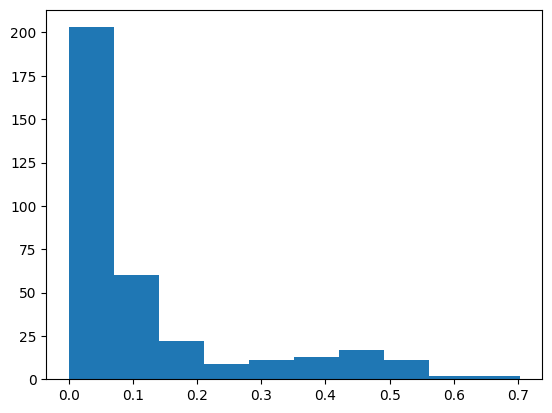

In [811]:
sims = cosine_similarity(A_tfidf, B_tfidf).diagonal()

plt.hist(sims)

In [812]:
threshold = 0.30 # got this value by looking at the histogram
df_1["cluster"] = sims >= threshold

# Subtask 2

In [813]:
df_2 = df_2.copy()

def clean_text(s: str) -> str:
    s = s.lower().strip()
    # keep only letters and spaces
    s = re.sub(r"[^a-z\s]", " ", s)
    # collapse multiple spaces
    s = re.sub(r"\s+", " ", s)
    return s

df_2["textA"] = df_2["textA"].apply(clean_text)

df_2.head()

,datapointID,textA,textB
0,120,o utse airs eaien eii llin cri,NaN
1,1168,e str er s ga ii hie ied al wi e aad en swih e...,NaN
2,796,den diin eipri skis eie ren ers ie taend ie ca...,NaN
3,114,he e kekcleazologuclea nem e hejen eleajecleaz...,NaN
4,989,licrhcrevbe coheleaenlicr gleaoup crhiileaed i...,NaN


In [830]:
vectorizer = TfidfVectorizer(
    analyzer="char_wb", ngram_range=(2, 6), sublinear_tf=True, min_df=2, max_df=0.9
)
X = vectorizer.fit_transform(df_2["textA"])

In [831]:
kmeans = KMeans(n_clusters=4, random_state=seed, n_init=20)
df_2['cluster'] = kmeans.fit_predict(X)

In [832]:
centroids = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()

for cl in range(4):
    top10 = np.argsort(centroids[cl])[-10:][::-1]
    print(f"Cluster {cl} top n-grams:", feature_names[top10])

Cluster 0 top n-grams: ['cw' 'sz' 'cs' 'ur' 'ku' 'kur' 'tt' 'iac' 'riac' 'kuri']
Cluster 1 top n-grams: ['clea' 'cle' 'ucle' 'uclea' 'gucl' 'gucle' 'guclea' 'guc' 'cl' 'gu']
Cluster 2 top n-grams: ['cr' 'icr' 'licr' 'lic' 'ic' 'li' 'ii' 'cr ' ' licr' ' lic']
Cluster 3 top n-grams: [' a' 'i ' 's ' ' i' 'er' 'ie' ' s' ' e' ' u' 't ']


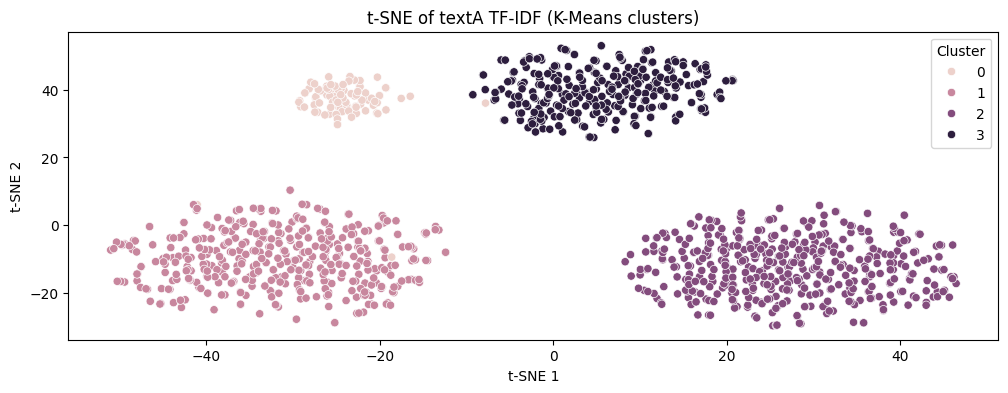

In [833]:
tsne = TSNE(n_components=2, random_state=seed, perplexity=30)
X_embedded = tsne.fit_transform(X.toarray())

df_2["tsne_x"], df_2["tsne_y"] = X_embedded[:, 0], X_embedded[:, 1]

plt.figure(figsize=(12, 4))
sns.scatterplot(x="tsne_x", y="tsne_y", hue="cluster", data=df_2)
plt.title("t-SNE of textA TF-IDF (K-Means clusters)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster")
plt.show()

# Submission

In [ ]:
# subtask 1
subtask1 = df_1["cluster"]

# subtask 2
subtask2 = df_2["cluster"].map(
    {0: "Hure", 1: "Hungeleabeen", 2: "Englcrevbeh", 3: "En Gli"}
)

In [839]:
def build_subtask_df(id, answer):
    return pd.DataFrame(
        {
            "subtaskID": id,
            "datapointID": df_1["datapointID"] if id == 1 else df_2["datapointID"],
            "answer": answer,
        },
    )


subtasks = [(1, subtask1), (2, subtask2)]

submission = pd.concat(
    [build_subtask_df(id, answer) for id, answer in subtasks], ignore_index=True
)

In [840]:
submission.head()

,subtaskID,datapointID,answer
0,1,1553,False
1,1,1537,False
2,1,1439,False
3,1,1322,False
4,1,1348,False


In [841]:
submission.to_csv("submission.csv", index=False)